In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from math import isnan
from collections import Counter
import random
pd.set_option('max_colwidth', -1)                # shows entire contents of pandas row

In [7]:
# data_file = "noun_devtest.csv"
data_file = "noun_train.csv"
raw_data_file = pd.read_csv(data_file)
raw_data_file.columns = [c.replace('.', '_') for c in raw_data_file.columns]

In [8]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_part = "Answer_noun_part" + str(idx + 1)
            var_part_c = "Answer_noun_part_certainty" + str(idx + 1)
            var_kind = "Answer_noun_class" + str(idx + 1)
            var_kind_c = "Answer_noun_class_certainty" + str(idx + 1)
            var_abs = "Answer_noun_abs" + str(idx + 1)
            var_abs_c = "Answer_noun_abs_certainty" + str(idx + 1)
            temp_dict['part'] = getattr(row, var_part)
            temp_dict['part_conf'] = getattr(row, var_part_c)
            temp_dict['kind'] = getattr(row, var_kind)
            temp_dict['kind_conf'] = getattr(row, var_kind_c)
            temp_dict['abs'] = getattr(row, var_abs)
            temp_dict['abs_conf'] = getattr(row, var_abs_c)
            temp_dict['worker_id'] = row.WorkerId
            temp_dict['hit_id'] = row.HITId
            temp_dict['status'] = row.AssignmentStatus
            global_list.append(temp_dict)
    
    return pd.DataFrame(global_list)

In [15]:
raw_data = extract_dataframe(raw_data_file)
raw_data = raw_data[raw_data['status']!='Rejected']
raw_data['sent_noun'] = raw_data['sent_id'].map(lambda x : x) + "_" + raw_data['noun_token'].map(lambda x: str(x))

cols = ['sent_noun', 'raw_sentence', 'noun', 'part', 'part_conf', 'kind', 'kind_conf', 'abs', 'abs_conf']
data = raw_data[cols]

x = list(data['sent_noun'].values)


In [60]:
data.loc[data['sent_noun'] == random.choice(x)]

,sent_noun,raw_sentence,noun,part,part_conf,kind,kind_conf,abs,abs_conf
3076,en-ud-train.conllu sent_6504_8,I do know that this will change the face of America .,face,True,4,True,4,False,4


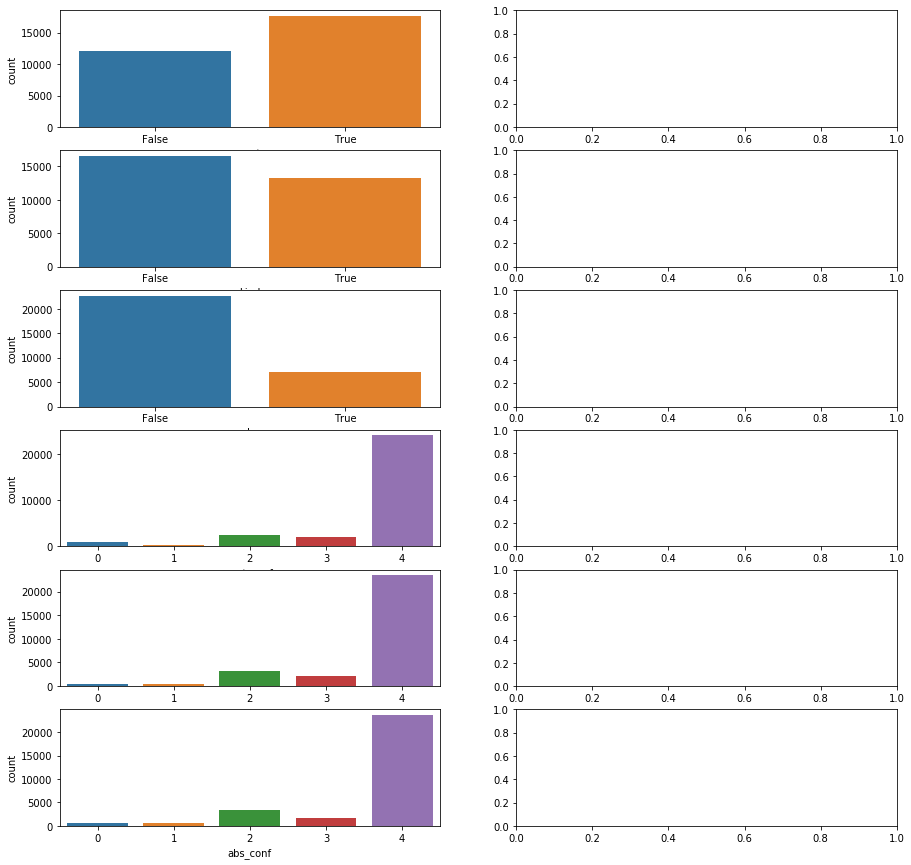

In [59]:
fig, axs = plt.subplots(ncols=2, nrows=6, figsize=(15, 15))
sns.countplot(x='part', data=data, ax=axs[0][0])
# sns.countplot(x='part', data=ann_data, ax=axs[0][1])
sns.countplot(x='kind', data=data, ax=axs[1][0])
# sns.countplot(x='kind', data=ann_data, ax=axs[1][1])
sns.countplot(x='abs', data=data, ax=axs[2][0])
# sns.countplot(x='abs', data=ann_data, ax=axs[2][1])

sns.countplot(x='part_conf', data=data, ax=axs[3][0])
# sns.countplot(x='part_conf', data=ann_data, ax=axs[3][1])
sns.countplot(x='kind_conf', data=data, ax=axs[4][0])
# sns.countplot(x='kind_conf', data=ann_data, ax=axs[4][1])
sns.countplot(x='abs_conf', data=data, ax=axs[5][0])
# sns.countplot(x='abs_conf', data=ann_data, ax=axs[5][1])

plt.show()

In [ ]:
print(data.pivot_table(index=['part', 'kind', 'abs'], 
                                  columns='kind_conf', 
                                  values='worker_id', aggfunc=len))
sns.heatmap(data.pivot_table(index=['part', 'kind', 'abs'], 
                                  columns='kind_conf', 
                                  values='worker_id', aggfunc=len).fillna(0))
plt.show()

### Response distribution

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.countplot(x='part', data=data, ax=axs[0][0])
sns.countplot(x='part_conf', data=data, ax=axs[0][1])
sns.countplot(x='kind', data=data, ax=axs[1][0])
sns.countplot(x='kind_conf', data=data, ax=axs[1][1])
sns.countplot(x='abs', data=data, ax=axs[2][0])
sns.countplot(x='abs_conf', data=data, ax=axs[2][1])

plt.show()

## Inter Annotator agreement

## Raw agreement

In [ ]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

part_agreement, key_part = calc_raw_agreement(data, 'sent_noun', 'part')
kind_agreement, key_kind = calc_raw_agreement(data, 'sent_noun', 'kind')
abs_agreement, key_abs = calc_raw_agreement(data, 'sent_noun', 'abs')

## Average of accuracy and kappa for each pair

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    accuracies = []
    lens = []
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        if not isnan(kappa(temp1, temp2)):
            kappas.append(kappa(temp1, temp2))
        else:
            kappas.append(0)
        accuracies.append(accuracy(temp1, temp2))
        lens.append(len(temp1))
    return kappas, accuracies, lens

def rank_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: pearson rank correlation

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    corrs = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        corrs.append(spearman(temp1, temp2)[0])
#         accuracies.append(accuracy(temp1, temp2))
        
    return corrs, accuracies

In [ ]:
# ridit scoring
# data['abs_conf']=data.groupby('worker_id').abs_conf.apply(lambda x: x.rank()/len(x))
# data['part_conf']=data.groupby('worker_id').part_conf.apply(lambda x: x.rank()/len(x))
# data['kind_conf']=data.groupby('worker_id').kind_conf.apply(lambda x: x.rank()/len(x))
kappas = {}
corrs = {}
accs = {}
lens_d = {}
variables = ['part', 'kind', 'abs']
variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var], accs[var], lens_d[var] = average_kappa_acc(data, 'worker_id', 'sent_noun', var)

for var in variables_ord:
    corrs[var], accs[var] = rank_correlation(data, 'worker_id', 'sent_noun', var)

In [ ]:
kappa_data = pd.DataFrame.from_dict(kappas)
# acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa")
plt.show()

# ax = sns.boxplot(data=acc_data)
# ax.set(ylabel='Accuracy', title="Accuracy")
# plt.show()

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()

kappa_mean = {'part':0, 'kind':0, 'abs':0}
for var in variables:
    total = sum(lens_d[var])
    kappa_mean[var] += sum([kappas[var][i] * lens_d[var][i] / total for i in range(len(lens_d[var]))])
print(np.mean(kappa_data))
print(kappa_mean) 
print(np.mean(corr_data))

In [ ]:
data['abs_conf']=data.groupby('worker_id').abs_conf.apply(lambda x: x.rank()/len(x))
data['part_conf']=data.groupby('worker_id').part_conf.apply(lambda x: x.rank()/len(x))
data['kind_conf']=data.groupby('worker_id').kind_conf.apply(lambda x: x.rank()/len(x))

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is 
    set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def ridit_dataframe(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    cols = ['hit_id','sent_noun','worker1_id','worker2_id','agreement']
    ridit_df = pd.DataFrame(columns=cols)
    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values[0]
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values[0]
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['hit_id'].values[0]
            agreement = (val1 == val2)
            temp_row = {'hit_id': val3, 'sent_noun': key, 'worker1_id': w1, 
                        'worker2_id': w2, 'agreement': agreement}
            ridit_df.append(temp_row, ignore_index=True)
            reversed_temp_row = {'hit_id': val3, 'sent_noun': key, 'worker1_id': w2, 
                                 'worker2_id': w1, 'agreement': agreement}
            ridit_df.append(reversed_temp_row, ignore_index=True)
        
    return ridit_df



In [ ]:
# The flipping happens here
# ridit_df = ridit_dataframe(data,'worker_id','sent_noun','part')
# ridit_df.head()

In [ ]:
# Enables the %%R magic 
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr); require(lme4)

# Run Mixed effects model in R

## Part

In [ ]:
%%R -i data -o df_part

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(part ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family=binomial)

#Model intercepts:
df_part = ranef(model)$worker_id
colnames(df_part) <- c('intercept')

df_part$glmer_intercept_part = df_part$intercept + 0.71698 #constant added manually
df_part$worker_id <- rownames(df_part)
print(summary(model))

In [ ]:
df_part['glmer_intercept_part'] = df_part['glmer_intercept_part'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_part.glmer_intercept_part.plot(kind='density')
plt.title("Annotator probability density of saying part = true")
plt.show()

## Kind

In [ ]:
%%R -i data -o df_kind

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(kind ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family="binomial")

#Model intercepts:
df_kind = ranef(model)$worker_id
colnames(df_kind) <- c('intercept')

df_kind$glmer_intercept_kind = df_kind$intercept - 0.115 #constant added manually
df_kind$worker_id <- rownames(df_kind)

print(summary(model))

In [ ]:
df_kind['glmer_intercept_kind'] = df_kind['glmer_intercept_kind'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_kind.glmer_intercept_kind.plot(kind='density')
plt.title("Annotator probability density of saying kind = true")
plt.show()

## Abs

In [ ]:
%%R -i data -o df_abs

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(abs ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family="binomial")

#Model intercepts:
df_abs = ranef(model)$worker_id
colnames(df_abs) <- c('intercept')

df_abs$glmer_intercept_abs = df_abs$intercept - 1.778 #constant added manually
df_abs$worker_id <- rownames(df_abs)

print(summary(model))

In [ ]:
df_abs['glmer_intercept_abs'] = df_abs['glmer_intercept_abs'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_abs.glmer_intercept_abs.plot(kind='density')
plt.title("Annotator probability density of saying abstract = true")
plt.show()

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    if check_var == "part":
        df = df_part
        int_prob = "glmer_intercept_part"
    elif check_var == "abs":
        df = df_abs
        int_prob = "glmer_intercept_abs"
    else:
        df = df_kind
        int_prob = "glmer_intercept_kind"

    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        accuracies.append(accuracy(temp1, temp2))
        # Now for modified kappa calculation
        p_e = (df[df[worker_id] == w1][int_prob][0] * df[df[worker_id] == w2][int_prob][0]) + ((1 - df[df[worker_id] == w1][int_prob][0]) * (1 - df[df[worker_id] == w2][int_prob][0]))
        kappas.append((accuracies[-1] - p_e) / (1 - p_e))
        
    return kappas, accuracies

In [ ]:
kappas = {}
corrs = {}
accs = {}
variables = ['part', 'kind', 'abs']
# variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(data, 'worker_id', 'sent_noun', var)
# for var in variables_ord:
#     corrs[var], accs[var] = rank_correlation(data, 'worker_id', 'sent_noun', var)

In [ ]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa")
plt.show()
print(np.mean(kappa_data))

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Accuracy")
plt.show()
print(np.mean(acc_data))